In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split

In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

In [3]:
# load the whole size dataset
X = np.load("London/X_all.npy")
Y_NO2 = np.load("London/Y_NO2_all.npy")
Y_PM10 = np.load("London/Y_PM10_all.npy")
Y_PM25 = np.load("London/Y_PM25_all.npy")

In [4]:
# calculate the symmetric mean absolute percentage error (SMAPE)
def get_score(pred, valid_y_exp):
    return np.mean(np.abs(pred - valid_y_exp) / (pred + valid_y_exp) * 2)

In [11]:
# lightgbm model parameters
# model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
model_param = {'lr': 0.1, 'depth': 10, 'tree': 300, 'leaf': 600, 'sample': 0.8, 'seed': 3}
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'max_depth': model_param['depth'],
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'feature_fraction': 1,
    'bagging_fraction': model_param['sample'],
    'bagging_freq': 1,
    'bagging_seed': model_param['seed'],
#     'min_sum_hessian_in_leaf': 100,
    'verbose': 0
}

# train and test the input X Y with the lightgbm model
def train_test(model_param, params, train_X, test_X, train_Y, test_Y, save_dir):
    time_start = time.time()
    lgb_train = lgb.Dataset(train_X, train_Y)
    lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=lgb_eval,
                    early_stopping_rounds=20)

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)
    return score

In [6]:
# PM 2.5

In [7]:
# split the Y_PM25, X into training part and testing part
train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25 = train_test_split(X, Y_PM25, test_size=0.2, random_state=11)
print(train_X_PM25.shape, test_X_PM25.shape, train_Y_PM25.shape, test_Y_PM25.shape)

(4325068, 198) (1081268, 198) (4325068,) (1081268,)


In [12]:
# model_param = {'lr': 0.1, 'depth': 10, 'tree': 400, 'leaf': 600, 'sample': 0.8, 'seed': 3}
score = train_test(model_param, params, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25.model")
print('score: ', score)

[1]	valid_0's l2: 106.027	valid_0's l1: 6.93052
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 88.2952	valid_0's l1: 6.34463
[3]	valid_0's l2: 73.9024	valid_0's l1: 5.82502
[4]	valid_0's l2: 62.1954	valid_0's l1: 5.36487
[5]	valid_0's l2: 52.6664	valid_0's l1: 4.95839
[6]	valid_0's l2: 44.9285	valid_0's l1: 4.59976
[7]	valid_0's l2: 38.6074	valid_0's l1: 4.28403
[8]	valid_0's l2: 33.4587	valid_0's l1: 4.00646
[9]	valid_0's l2: 29.2474	valid_0's l1: 3.7631
[10]	valid_0's l2: 25.7994	valid_0's l1: 3.5507
[11]	valid_0's l2: 22.9826	valid_0's l1: 3.36524
[12]	valid_0's l2: 20.6583	valid_0's l1: 3.20397
[13]	valid_0's l2: 18.7451	valid_0's l1: 3.06397
[14]	valid_0's l2: 17.1781	valid_0's l1: 2.94231
[15]	valid_0's l2: 15.8898	valid_0's l1: 2.83734
[16]	valid_0's l2: 14.801	valid_0's l1: 2.7461
[17]	valid_0's l2: 13.9172	valid_0's l1: 2.66771
[18]	valid_0's l2: 13.1725	valid_0's l1: 2.59926
[19]	valid_0's l2: 12.5411	valid_0's l1: 2.5393
[20]	valid_0's l2: 12

In [13]:
gbm = read_pkl("London/lightgbm_PM25.model")
test_X = np.load("London/X_test.npy")
test_Y = np.load("London/Y_PM25_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.3012901336557956

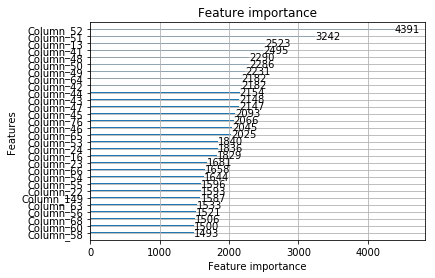

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [ ]:
# model_param = {'lr': 0.1, 'depth': 10, 'tree': 400, 'leaf': 600, 'sample': 0.8, 'seed': 3}

# score = train_test(model_param, params, train_X_PM25, test_X_PM25, train_Y_PM25, test_Y_PM25, "London/lightgbm_PM25.model")
# print('score: ', score)

In [15]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# ax = lgb.plot_importance(gbm, max_num_features=20)
# plt.show()

In [ ]:
# PM 10

In [16]:
# split the Y_PM10, X into training part and testing part

# train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10 = train_test_split(X, Y_PM10, test_size=0.2, random_state=11)
# print(train_X_PM10.shape, test_X_PM10.shape, train_Y_PM10.shape, test_Y_PM10.shape)

In [17]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model
# 48+ features and model_param = {'lr': 0.1, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}

# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [18]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model

# model_param = {'lr': 0.01, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [19]:
# model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [20]:
# model_param = {'lr': 0.01, 'depth': 10, 'tree': 10000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# score = train_test(model_param, params, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
# print('score: ', score)

In [12]:
# PM10_Concentration = train_X_PM10[:,1]
# s = get_score(PM10_Concentration.reshape((PM10_Concentration.shape[0], 1)), train_Y_PM10)
# print(s)

# PM10_Concentration = test_X_PM10[:,1]
# s = get_score(PM10_Concentration.reshape((PM10_Concentration.shape[0], 1)), test_Y_PM10)
# print(s)

In [ ]:
# NO2

In [21]:
# split the Y_NO2, X into training part and testing part

# train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2, random_state=11)
# print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

In [6]:
# np.save("London/train_X_NO2_all.npy", train_X_NO2)

In [7]:
# np.save("London/test_X_NO2_all.npy", test_X_NO2)

In [8]:
# np.save("London/train_Y_NO2_all.npy", train_Y_NO2)

In [9]:
# np.save("London/test_Y_NO2_all.npy", test_Y_NO2)

In [22]:
# New model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# (5394355, 125)

# score = train_test(model_param, params, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "London/lightgbm_NO2.model")
# print('score: ', score)

In [4]:
# load the whole size dataset
train_X_NO2 = np.load("London/train_X_NO2_all.npy")
test_X_NO2 = np.load("London/test_X_NO2_all.npy")
train_Y_NO2 = np.load("London/train_Y_NO2_all.npy")
test_Y_NO2 = np.load("London/test_Y_NO2_all.npy")

In [23]:
# New model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}
# (5370393, 241)

# score = train_test(model_param, params, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "London/lightgbm_NO2.model")
# print('score: ', score)